<a href="https://colab.research.google.com/github/skywalker0803r/python-tutoring-materials/blob/main/%E8%AA%B2%E7%A8%8B/pytorch_lightning_single_fold_training_lb_0_97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Owerview of the Competition:
## **Task:**

In this competition we are tasked with looking for technosignature signals in cadence snippets taken from the Green Bank Telescope (GBT)

## **What do we have at our hands:**

* **train** - a training set of cadence snippet files stored in numpy float16 format, one file per cadence snippet id, with corresponding labels found in the train_labels.csv file. Each file has dimension (6, 273, 256), with the 1st dimension representing the 6 positions of the cadence, and the 2nd and 3rd dimensions representing the 2D spectrogram.
* **test**- the test set cadence snippet files; you must predict whether or not the cadence contains a "needle", which is the target for this competition.
* **sample_submission.csv** - a sample submission file in the correct format.
* **train_labels** - targets corresponding (by id) to the cadence snippet files found in the train/ folder.


In [ ]:
!pip -q install timm
!pip -q install pytorch_lightning

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, OneCycleLR
from torch.optim.optimizer import Optimizer
import torchvision.utils as vutils

import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Config

In [ ]:
SEED = 42
N_FOLDS = 5
TRAIN_FOLD = 0
TARGET_COL = 'target'
N_EPOCHS = 10
BATCH_SIZE = 32
IMG_SIZE = 640
LR = 1e-4
MAX_LR = 5e-4
PRECISION = 16
MODEL = 'efficientnet_b0'

In [ ]:
def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state


random_state = set_seed(SEED)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("GPU not available, going to use CPU instead.")

GPU is available.


# Taking First Look into Data

In [ ]:
train = pd.read_csv('../input/seti-breakthrough-listen/train_labels.csv')
test = pd.read_csv('../input/seti-breakthrough-listen/sample_submission.csv')

def get_train_file_path(image_id):
    return "../input/seti-breakthrough-listen/train/{}/{}.npy".format(image_id[0], image_id)

def get_test_file_path(image_id):
    return "../input/seti-breakthrough-listen/test/{}/{}.npy".format(image_id[0], image_id)

train['file_path'] = train['id'].apply(get_train_file_path)
test['file_path'] = test['id'].apply(get_test_file_path)

display(train.sample(5))

,id,target,file_path
4256,155e40cc7dc1,0,../input/seti-breakthrough-listen/train/1/155e...
31961,a2e3f473511c,0,../input/seti-breakthrough-listen/train/a/a2e3...
8161,297d6cc4529f,0,../input/seti-breakthrough-listen/train/2/297d...
9246,2effda776e01,0,../input/seti-breakthrough-listen/train/2/2eff...
2885,0ed73f5f004e,0,../input/seti-breakthrough-listen/train/0/0ed7...


In [ ]:
dist = train.target.map({0:'haystack', 1:'needle'})
dist = dist.value_counts()
fig = px.pie(dist,
             values='target',
             names=dist.index,
             hole=.4,title="Target Distribution")
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

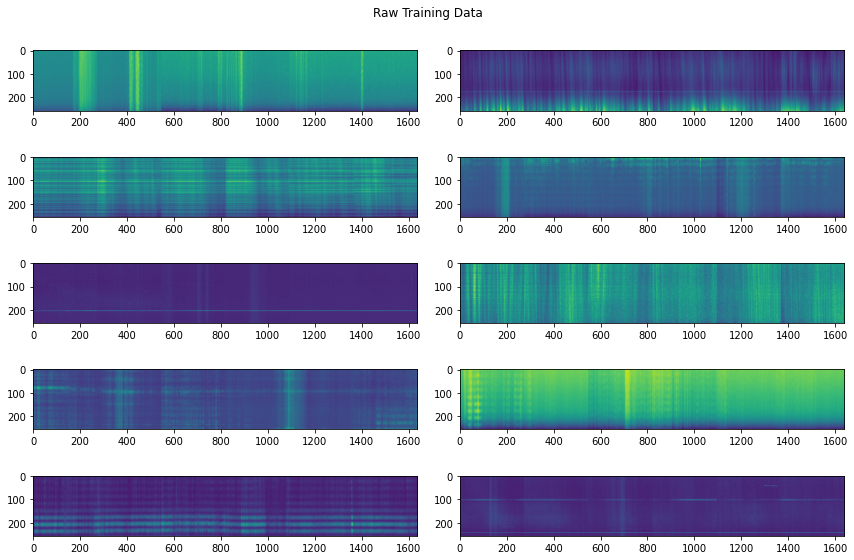

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(10):
    if i < 4:
        image = np.load(train.loc[i, 'file_path'])
    else:
        image = np.load(train[train['target']==1].reset_index().loc[i, 'file_path'])
    image = image.astype(np.float32)
    image = np.vstack(image).T
    plt.subplot(5, 2, i + 1)
    plt.imshow(image)
plt.suptitle("Raw Training Data")
plt.tight_layout()

# Dataset

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, df, test=False, transform=None):
        self.df = df
        self.test = test
        self.file_names = df['file_path'].values
        if not self.test:
            self.labels = df[TARGET_COL].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        
        image = np.load(file_path)[[0, 2, 4]] 
        image = image.astype(np.float32)
        image = np.vstack(image).T 
        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
        if not self.test:
            label = torch.unsqueeze(torch.tensor(self.labels[idx]).float(),-1)
            return image, label
        else:
            return image

In [ ]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(IMG_SIZE,
                    IMG_SIZE),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE),
            ToTensorV2(),
        ])

### Let's check if our dataloaders are working fine...

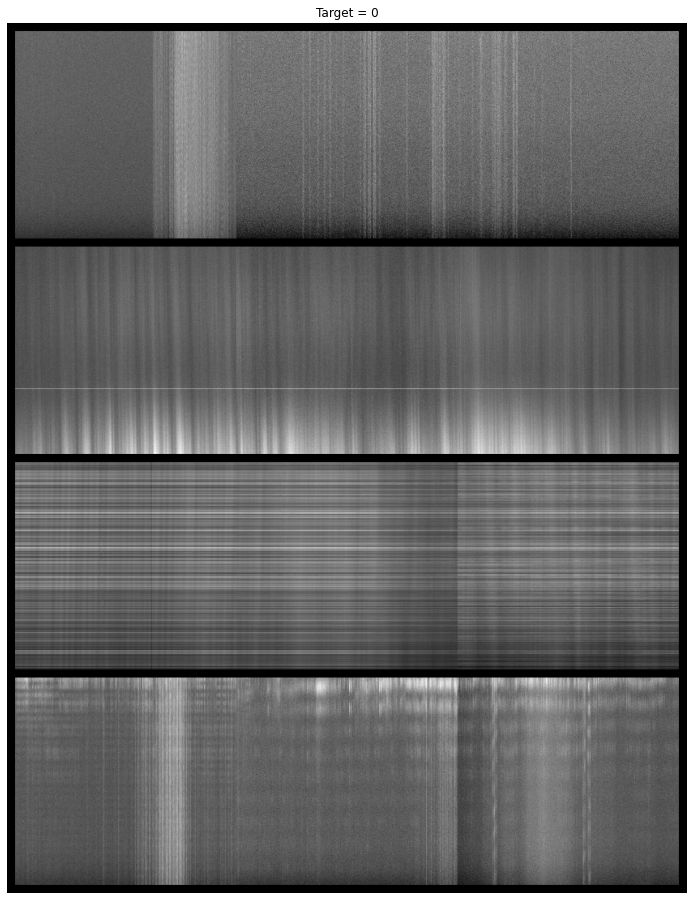

In [ ]:
def train_dataloader():
    return DataLoader(train_dataset, batch_size=4, num_workers=2,
                      drop_last=False, shuffle=False, pin_memory=True)
train_dataset = TrainDataset(train[train['target']==0], transform=None)
batch, targets = next(iter(train_dataloader()))

plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Target = 0")
plt.imshow(vutils.make_grid(
    batch, nrow=1, padding=10, normalize=True).permute(1,2,0).cpu().numpy())
plt.show()

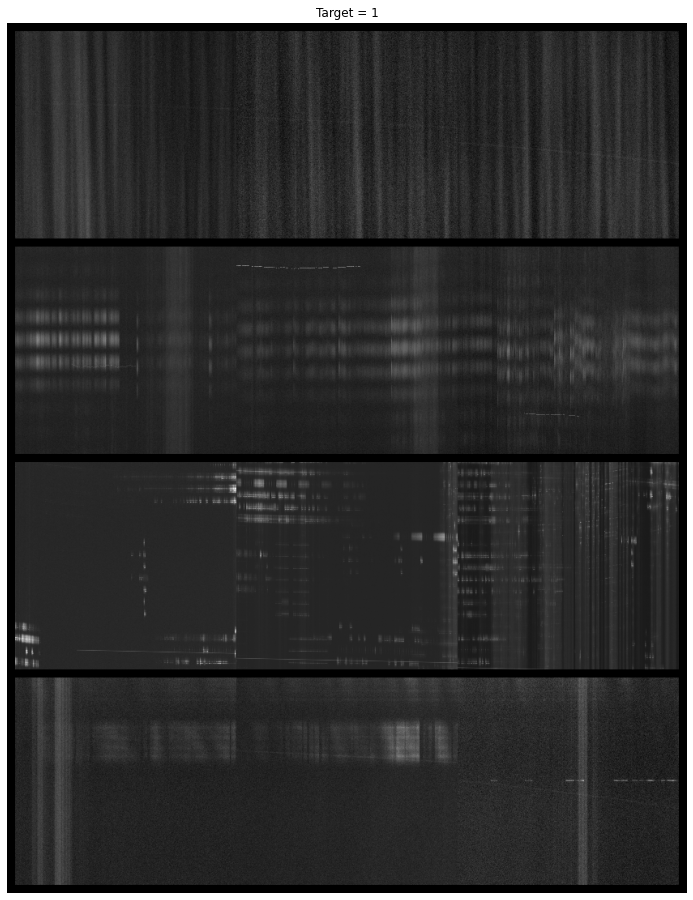

In [ ]:
train_dataset = TrainDataset(train[train['target']==1], transform=None)
batch, targets = next(iter(train_dataloader()))

plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Target = 1")
plt.imshow(vutils.make_grid(
    batch, nrow=1, padding=10, normalize=True).permute(1,2,0).cpu().numpy())
plt.show()

# Data Module

In [ ]:
class DataModule(pl.LightningDataModule):

    def __init__(self, train_df, val_df, test_df,  batch_size=8):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    def setup(self, stage=None):
        self.train_dataset = TrainDataset(
          self.train_df,
          transform=get_transforms(data='train')
            
        )
        
        self.val_dataset = TrainDataset(          
          self.val_df,
          transform=get_transforms(data='valid')
        )

        self.test_dataset = TrainDataset(
          self.test_df,
          transform=get_transforms(data='valid'),
          test = True
        )

    def train_dataloader(self):
        return DataLoader(
          self.train_dataset,
          batch_size=self.batch_size,
          shuffle=True,
          num_workers=4,
          pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
          self.val_dataset,
          batch_size=self.batch_size,
          num_workers=4,
          pin_memory=True
        )

    def test_dataloader(self):
        return DataLoader(
          self.test_dataset,
          batch_size=self.batch_size,
          num_workers=4,
          pin_memory=True
        )

# Mixup

In [ ]:
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]

    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# MADGRAD

In [ ]:
import math
from typing import TYPE_CHECKING, Any, Callable, Optional

if TYPE_CHECKING:
    from torch.optim.optimizer import _params_t
else:
    _params_t = Any

class MADGRAD(Optimizer):

    def __init__(
        self, params: _params_t, lr: float = 1e-2, momentum: float = 0.9, weight_decay: float = 0, eps: float = 1e-6,
    ):
        if momentum < 0 or momentum >= 1:
            raise ValueError(f"Momentum {momentum} must be in the range [0,1]")
        if lr <= 0:
            raise ValueError(f"Learning rate {lr} must be positive")
        if weight_decay < 0:
            raise ValueError(f"Weight decay {weight_decay} must be non-negative")
        if eps < 0:
            raise ValueError(f"Eps must be non-negative")

        defaults = dict(lr=lr, eps=eps, momentum=momentum, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self) -> bool:
        return False

    @property
    def supports_flat_params(self) -> bool:
        return True

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:

        loss = None
        if closure is not None:
            loss = closure()

        if 'k' not in self.state:
            self.state['k'] = torch.tensor([0], dtype=torch.long)
        k = self.state['k'].item()

        for group in self.param_groups:
            eps = group["eps"]
            lr = group["lr"] + eps
            decay = group["weight_decay"]
            momentum = group["momentum"]

            ck = 1 - momentum
            lamb = lr * math.pow(k + 1, 0.5)

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if "grad_sum_sq" not in state:
                    state["grad_sum_sq"] = torch.zeros_like(p.data).detach()
                    state["s"] = torch.zeros_like(p.data).detach()
                    if momentum != 0:
                        state["x0"] = torch.clone(p.data).detach()

                if momentum != 0.0 and grad.is_sparse:
                    raise RuntimeError("momentum != 0 is not compatible with sparse gradients")

                grad_sum_sq = state["grad_sum_sq"]
                s = state["s"]

                # Apply weight decay
                if decay != 0:
                    if grad.is_sparse:
                        raise RuntimeError("weight_decay option is not compatible with sparse gradients")

                    grad.add_(p.data, alpha=decay)

                if grad.is_sparse:
                    grad = grad.coalesce()
                    grad_val = grad._values()

                    p_masked = p.sparse_mask(grad)
                    grad_sum_sq_masked = grad_sum_sq.sparse_mask(grad)
                    s_masked = s.sparse_mask(grad)

                    # Compute x_0 from other known quantities
                    rms_masked_vals = grad_sum_sq_masked._values().pow(1 / 3).add_(eps)
                    x0_masked_vals = p_masked._values().addcdiv(s_masked._values(), rms_masked_vals, value=1)

                    # Dense + sparse op
                    grad_sq = grad * grad
                    grad_sum_sq.add_(grad_sq, alpha=lamb)
                    grad_sum_sq_masked.add_(grad_sq, alpha=lamb)

                    rms_masked_vals = grad_sum_sq_masked._values().pow_(1 / 3).add_(eps)

                    s.add_(grad, alpha=lamb)
                    s_masked._values().add_(grad_val, alpha=lamb)

                    # update masked copy of p
                    p_kp1_masked_vals = x0_masked_vals.addcdiv(s_masked._values(), rms_masked_vals, value=-1)
                    # Copy updated masked p to dense p using an add operation
                    p_masked._values().add_(p_kp1_masked_vals, alpha=-1)
                    p.data.add_(p_masked, alpha=-1)
                else:
                    if momentum == 0:
                        # Compute x_0 from other known quantities
                        rms = grad_sum_sq.pow(1 / 3).add_(eps)
                        x0 = p.data.addcdiv(s, rms, value=1)
                    else:
                        x0 = state["x0"]

                    # Accumulate second moments
                    grad_sum_sq.addcmul_(grad, grad, value=lamb)
                    rms = grad_sum_sq.pow(1 / 3).add_(eps)

                    # Update s
                    s.data.add_(grad, alpha=lamb)

                    # Step
                    if momentum == 0:
                        p.data.copy_(x0.addcdiv(s, rms, value=-1))
                    else:
                        z = x0.addcdiv(s, rms, value=-1)

                        # p is a moving average of z
                        p.data.mul_(1 - ck).add_(z, alpha=ck)


        self.state['k'] += 1
        return loss

# Model

In [ ]:
class Predictor(pl.LightningModule):

    def __init__(self, n_classes: int, n_training_steps=None, steps_per_epoch=None):
        super().__init__()
        self.n_classes = n_classes
        self.model = timm.create_model(MODEL, pretrained=True, in_chans=1)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.n_features, n_classes)
        self.n_training_steps = n_training_steps
        self.steps_per_epoch = steps_per_epoch

    def forward(self, x):
        output = self.model(x)
        return output


    def training_step(self, batch, batch_idx):

        x, y = batch
        
        x, y_a, y_b, lam = mixup_data(x, y.view(-1, 1))
        
        output = self(x)
        labels = y
        loss = mixup_criterion(criterion, output, y_a, y_b, lam)
        try:
            auc=roc_auc_score(labels.detach().cpu(), output.sigmoid().detach().cpu())        
            self.log("auc", auc, prog_bar=True, logger=True)
        except:
            pass
        return {"loss": loss, "predictions": output, "labels": labels}

    def training_epoch_end(self, outputs):

        preds = []
        labels = []
        
        for output in outputs:
          
          preds += output['predictions']
          labels += output['labels']

        labels = torch.stack(labels)
        preds = torch.stack(preds)


        train_auc=roc_auc_score(labels.detach().cpu(), preds.sigmoid().detach().cpu())
        self.log("mean_train_auc", train_auc, prog_bar=True, logger=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        labels = y
        loss = criterion(output, y)
        self.log('val_loss', loss, prog_bar=True, logger=True)
        return {"predictions": output, "labels": labels}
      

    def validation_epoch_end(self, outputs):

        preds = []
        labels = []
        
        for output in outputs:
          
          preds += output['predictions']
          labels += output['labels']

        labels = torch.stack(labels)
        preds = torch.stack(preds)

        val_auc=roc_auc_score(labels.detach().cpu(), preds.sigmoid().detach().cpu())
        self.log("val_auc", val_auc, prog_bar=True, logger=True)
        

    def test_step(self, batch, batch_idx):
        x = batch        
        output = self(x).sigmoid()
        return output   



    def configure_optimizers(self):

        optimizer = MADGRAD(self.parameters(), lr=LR)

        scheduler = OneCycleLR(
          optimizer,
          epochs = N_EPOCHS,
          max_lr = MAX_LR,
          total_steps = self.n_training_steps,
          steps_per_epoch = self.steps_per_epoch
        )

        return dict(
          optimizer=optimizer,
          lr_scheduler=scheduler
        )

In [ ]:
t_steps_per_epoch=(len(train)// N_EPOCHS) // BATCH_SIZE
total_training_steps = t_steps_per_epoch * N_EPOCHS
criterion=nn.BCEWithLogitsLoss()

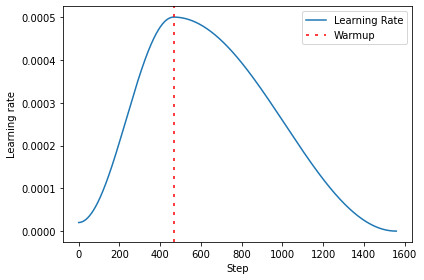

In [ ]:
dummy_model = nn.Linear(2, 1)

optimizer = MADGRAD(params=dummy_model.parameters(), lr=LR)



scheduler = OneCycleLR(
          optimizer,
          epochs = N_EPOCHS,
          max_lr = MAX_LR,
          total_steps = total_training_steps,
          steps_per_epoch = t_steps_per_epoch
        )

learning_rate_history = []

for step in range(total_training_steps):

    optimizer.step()

    scheduler.step()

    learning_rate_history.append(optimizer.param_groups[0]['lr'])

plt.plot(learning_rate_history, label="Learning Rate")

plt.axvline(x=total_training_steps*0.3, color="red", linestyle=(0, (2, 4)), label="Warmup")

plt.legend()

plt.xlabel("Step")

plt.ylabel("Learning rate")

plt.tight_layout()

# Training

In [ ]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
train["fold"] = -1
for fold_id, (_, val_idx) in enumerate(skf.split(train["id"], train["target"])):
    train.loc[val_idx, "fold"] = fold_id
    
    
model = Predictor(steps_per_epoch=t_steps_per_epoch,
                  n_training_steps=total_training_steps ,
                  n_classes=1
    )


data_module = DataModule(
  train[train['fold']!=TRAIN_FOLD], # train fold
  train[train['fold']==TRAIN_FOLD], # val fold
  train[train['fold']==TRAIN_FOLD], # test data, same as val for now
  batch_size=BATCH_SIZE,
)
early_stopping_callback = EarlyStopping(monitor='val_auc',mode="max", patience=2)
checkpoint_callback = ModelCheckpoint(
  #dirpath="checkpoints",
  #filename="best-checkpoint-ep{epoch:02d}-{val_auc:.3f}",
  save_top_k=N_EPOCHS,
  verbose=True,
  monitor="val_auc",
  mode="max"
)
trainer = pl.Trainer(
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  precision=PRECISION,
  progress_bar_refresh_rate=5
)
trainer.fit(model, data_module)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

# Inference

In [ ]:
predictions = []
trained_model = Predictor.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=1
)
trained_model.eval()
trained_model.freeze()
trained_model = trained_model.to(device)
val_dataset = TrainDataset(
      test,
      transform=get_transforms(data='valid'),
      test = True
    )
dataloader=DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
for item in tqdm(dataloader, position=0, leave=True):
    prediction = trained_model(item.to(device))
    predictions.append(prediction.flatten().sigmoid())
predictions = torch.cat(predictions).detach().cpu()
final_preds=predictions.squeeze(-1).numpy()

100%|██████████| 281/281 [04:30<00:00,  1.04it/s]


# Submission

In [ ]:
submission = pd.read_csv('../input/seti-breakthrough-listen/sample_submission.csv')
submission['target'] = final_preds
submission.to_csv('sub.csv', index=False)
submission.head()

,id,target
0,00034db451c4,0.008685
1,0006316b5ca0,0.001521
2,0006a953d21b,0.046534
3,0008a33d6695,0.032498
4,00095b5119fc,0.011968


### That all folks, I hope you find it useful. I might have missed some points like markdowns in general or some code parts,I'm planning to fill those parts ehenever I have free time. Anyways if you have any questions you can leave a comment below and if you liked the notebook please don't forget to upvote. Happy coding!